In [1]:
import json
import os
import requests
import logging
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Optional, Union, Tuple, Callable, Awaitable, TypeVar, Generic
from matplotlib import pyplot as plt

def init_logger(current_name: str = __name__):
    """Allows for initializing loggers in threads as well."""
    logger = logging.getLogger(current_name)
    if len(logger.handlers) == 0:
        logger.setLevel(logging.INFO)
        sh = logging.StreamHandler()
        sh.setFormatter(
            logging.Formatter("%(asctime)s %(levelname)s [%(process)d] - %(message)s")
        )
        logger.addHandler(sh)
    return logger

logger = init_logger()

BASE_DATA_PATH = "../../data/"
BASE_IMAGE_PATH = os.path.join(BASE_DATA_PATH, "images")
BASE_IMAGE_RESIZED_PATH = os.path.join(BASE_DATA_PATH, "images_resized")


In [2]:
def get_flare_events(start_date, end_date) -> List:
    """https://ccmc.gsfc.nasa.gov/support/DONKI-webservices.php#FLR"""

    api_url = f"https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/FLR?startDate={start_date}&endDate={end_date}"
    
    try:
        response = requests.get(api_url)
        response.raise_for_status()
        if response.status_code == 200:
            flare_events = response.json()
            return flare_events
        else:
            logger.error(f"Failed to fetch data. Status code: {response.status_code}")
            return []
    except Exception as e:
        logger.exception(f"Failed to fetch data.")
        return []
    
def parse_data(data):
    data['beginTime'] = pd.to_datetime(data['beginTime']).to_pydatetime()
    data['peakTime'] = pd.to_datetime(data['peakTime']).to_pydatetime()
    data['endTime'] = pd.to_datetime(data['endTime']).to_pydatetime() if data['endTime'] is not None else None
    data['instruments'] = [instrument['displayName'] for instrument in data['instruments']]
    if data['linkedEvents'] is None:
        data['linkedEvents'] = []
    return data

In [3]:

all_events = []
for year in range(2011, 2019):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    flare_events: List[Dict[str, Any]] = get_flare_events(start_date, end_date)
    all_events.extend(flare_events)
    logger.info(f"Year {year} done.")


2024-05-30 21:28:28,599 INFO [182928] - Year 2011 done.
2024-05-30 21:28:30,107 INFO [182928] - Year 2012 done.
2024-05-30 21:28:31,313 INFO [182928] - Year 2013 done.
2024-05-30 21:28:34,228 INFO [182928] - Year 2014 done.
2024-05-30 21:28:36,404 INFO [182928] - Year 2015 done.
2024-05-30 21:28:37,278 INFO [182928] - Year 2016 done.
2024-05-30 21:28:38,673 INFO [182928] - Year 2017 done.
2024-05-30 21:28:39,178 INFO [182928] - Year 2018 done.


In [4]:
df = pd.DataFrame(all_events, columns=["flrID", "instruments", "beginTime", "peakTime", "endTime", "classType", "sourceLocation", "activeRegionNum", "linkedEvents", "link"])
df['beginTime'] = pd.to_datetime(df['beginTime'])
df['peakTime'] = pd.to_datetime(df['peakTime'])
df['endTime'] = pd.to_datetime(df['endTime']) if df['endTime'] is not None else None
df.set_index('flrID', inplace=True)
df.head()

,instruments,beginTime,peakTime,endTime,classType,sourceLocation,activeRegionNum,linkedEvents,link
flrID,,,,,,,,,
2011-01-28T00:44:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-01-28 00:44:00+00:00,2011-01-28 01:03:00+00:00,2011-01-28 01:10:00+00:00,M1.3,N17W88,11149.0,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
2011-02-09T01:23:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-09 01:23:00+00:00,2011-02-09 01:31:00+00:00,2011-02-09 01:35:00+00:00,M1.9,N16W70,11153.0,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
2011-02-13T17:28:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-13 17:28:00+00:00,2011-02-13 17:38:00+00:00,2011-02-13 17:47:00+00:00,M6.6,S20E04,11158.0,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
2011-02-14T17:20:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-14 17:20:00+00:00,2011-02-14 17:26:00+00:00,2011-02-14 17:32:00+00:00,M2.2,S20W04,11158.0,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...
2011-02-15T01:44:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-15 01:44:00+00:00,2011-02-15 01:56:00+00:00,2011-02-15 02:06:00+00:00,X2.2,S20W10,11158.0,[{'activityID': '2011-02-15T02:25:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...


In [5]:
# clean up end time
df['endTime'] = df.apply(lambda row: row['peakTime'] + pd.Timedelta(minutes=30) if pd.isnull(row['endTime']) else row['endTime'], axis=1)
# print(df['endTime'].isnull().sum(), df['peakTime'].isnull().sum())

# fix individual end-times
df.loc['2016-11-29T23:29:00-FLR-001', 'endTime'] = df.loc['2016-11-29T23:29:00-FLR-001']['endTime'] - pd.DateOffset(days=1)
df.loc['2017-09-04T18:05:00-FLR-001', 'endTime'] = df.loc['2017-09-04T18:05:00-FLR-001']['endTime'] - pd.DateOffset(years=2)
df.loc['2017-09-08T23:34:00-FLR-001', 'endTime'] = df.loc['2017-09-08T23:34:00-FLR-001']['endTime'] - pd.DateOffset(days=1)
df.loc['2017-10-20T23:10:00-FLR-001', 'endTime'] = df.loc['2017-10-20T23:10:00-FLR-001']['endTime'] - pd.DateOffset(days=1)
df.loc['2014-03-08T23:26:00-FLR-001', 'endTime'] = df.loc['2014-03-08T23:26:00-FLR-001']['endTime'] + pd.DateOffset(days=1)
df.loc['2014-05-07T16:07:00-FLR-001', 'endTime'] = df.loc['2014-05-07T16:07:00-FLR-001']['endTime'] + pd.DateOffset(hours=4)
df.loc['2014-06-15T23:44:00-FLR-001', 'endTime'] = df.loc['2014-06-15T23:44:00-FLR-001']['endTime'] + pd.DateOffset(days=1)

# fix individual begin-times
df.loc['2014-01-28T12:50:00-FLR-001', 'beginTime'] = df.loc['2014-01-28T12:50:00-FLR-001']['beginTime'] - pd.DateOffset(minutes=10)
df.loc['2016-01-01T23:00:00-FLR-001', 'beginTime'] = df.loc['2016-01-01T23:00:00-FLR-001']['beginTime'] - pd.DateOffset(years=1)

# fix individual peak-times
df.loc['2015-06-20T06:28:00-FLR-001', 'peakTime'] = df.loc['2015-06-20T06:28:00-FLR-001']['peakTime'] - pd.DateOffset(years=1)

# Switch peak and endtime if endtime is before peak time

def calc_extra_columns(row):
    row['peak_begin_diff'] = row['peakTime'] - row['beginTime']
    row['end_peak_diff'] = row['endTime'] - row['peakTime']
    row['end_begin_diff'] = row['endTime'] - row['beginTime']
    return row

def switch_peak_end(row):
    if row['end_peak_diff'] < pd.Timedelta('0 days'):
        row['peakTime'], row['endTime'] = row['endTime'], row['peakTime']
    return row

df = df.apply(calc_extra_columns, axis=1)
df = df.apply(switch_peak_end, axis=1)

df.head()

,instruments,beginTime,peakTime,endTime,classType,sourceLocation,activeRegionNum,linkedEvents,link,peak_begin_diff,end_peak_diff,end_begin_diff
flrID,,,,,,,,,,,,
2011-01-28T00:44:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-01-28 00:44:00+00:00,2011-01-28 01:03:00+00:00,2011-01-28 01:10:00+00:00,M1.3,N17W88,11149.0,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:19:00,0 days 00:07:00,0 days 00:26:00
2011-02-09T01:23:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-09 01:23:00+00:00,2011-02-09 01:31:00+00:00,2011-02-09 01:35:00+00:00,M1.9,N16W70,11153.0,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:08:00,0 days 00:04:00,0 days 00:12:00
2011-02-13T17:28:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-13 17:28:00+00:00,2011-02-13 17:38:00+00:00,2011-02-13 17:47:00+00:00,M6.6,S20E04,11158.0,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:10:00,0 days 00:09:00,0 days 00:19:00
2011-02-14T17:20:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-14 17:20:00+00:00,2011-02-14 17:26:00+00:00,2011-02-14 17:32:00+00:00,M2.2,S20W04,11158.0,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:06:00,0 days 00:06:00,0 days 00:12:00
2011-02-15T01:44:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-15 01:44:00+00:00,2011-02-15 01:56:00+00:00,2011-02-15 02:06:00+00:00,X2.2,S20W10,11158.0,[{'activityID': '2011-02-15T02:25:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:12:00,0 days 00:10:00,0 days 00:22:00


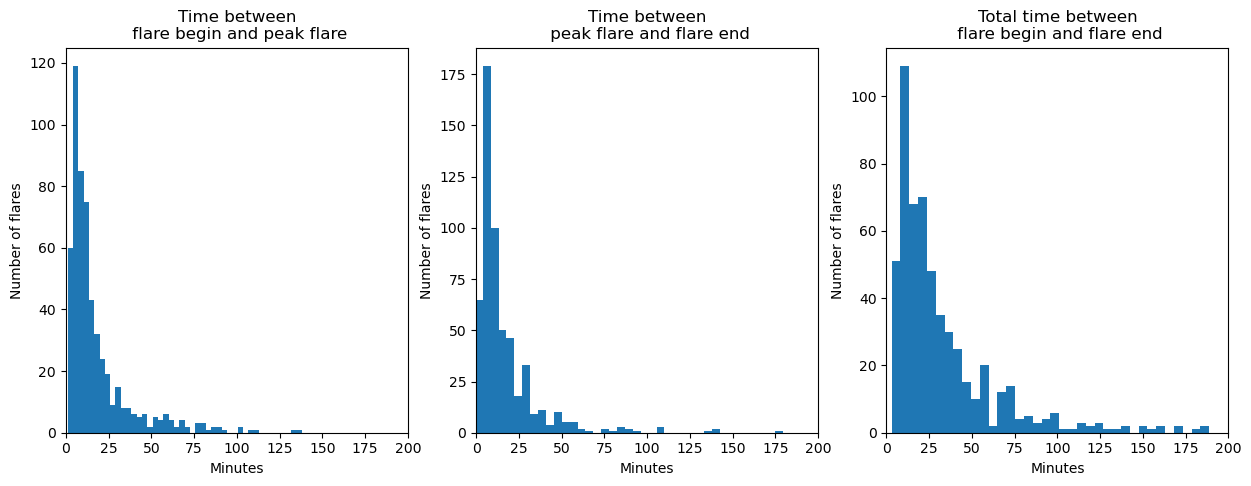

In [6]:
# begin-peak distribution

subset = df.copy()
# subset = subset[subset['peak_begin_diff'] < pd.Timedelta('1 days')]
# subset = subset[subset['peak_begin_diff'] > pd.Timedelta('0 days')]

fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)

subset['peak_begin_diff'] = subset['peak_begin_diff'].dt.total_seconds() / 60
subset['end_peak_diff'] = subset['end_peak_diff'].dt.total_seconds() / 60
subset['end_begin_diff'] = subset['end_begin_diff'].dt.total_seconds() / 60

# Add histogram plot to ax
xlim = (0, 200)

ax[0].hist(subset['peak_begin_diff'], bins=100)
ax[0].set_title('Time between\n flare begin and peak flare')
ax[0].set_xlim(*xlim)
ax[0].set_xlabel('Minutes')
ax[0].set_ylabel('Number of flares')

ax[1].hist(subset['end_peak_diff'], bins=100)
ax[1].set_title('Time between\n peak flare and flare end')
ax[1].set_xlim(*xlim)
ax[1].set_xlabel('Minutes')
ax[1].set_ylabel('Number of flares')

ax[2].hist(subset['end_begin_diff'], bins=100)
ax[2].set_title('Total time between\n flare begin and flare end')
ax[2].set_xlim(*xlim)
ax[2].set_xlabel('Minutes')
ax[2].set_ylabel('Number of flares')

plt.show()


In [7]:
df[df['classType'].str.startswith('X')].head()

,instruments,beginTime,peakTime,endTime,classType,sourceLocation,activeRegionNum,linkedEvents,link,peak_begin_diff,end_peak_diff,end_begin_diff
flrID,,,,,,,,,,,,
2011-02-15T01:44:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-02-15 01:44:00+00:00,2011-02-15 01:56:00+00:00,2011-02-15 02:06:00+00:00,X2.2,S20W10,11158.0,[{'activityID': '2011-02-15T02:25:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:12:00,0 days 00:10:00,0 days 00:22:00
2011-03-09T23:13:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-03-09 23:13:00+00:00,2011-03-09 23:23:00+00:00,2011-03-09 23:29:00+00:00,X1.5,N11W14,NaN,None,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:10:00,0 days 00:06:00,0 days 00:16:00
2011-08-09T07:48:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-08-09 07:48:00+00:00,2011-08-09 08:05:00+00:00,2011-08-09 08:08:00+00:00,X6.9,N17W69,11263.0,[{'activityID': '2011-08-09T08:40:00-SEP-001'}...,https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:17:00,0 days 00:03:00,0 days 00:20:00
2011-09-06T22:12:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-09-06 22:12:00+00:00,2011-09-06 22:20:00+00:00,2011-09-06 22:24:00+00:00,X2.1,N14W17,11283.0,[{'activityID': '2011-09-07T06:00:00-SEP-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:08:00,0 days 00:04:00,0 days 00:12:00
2011-09-07T22:32:00-FLR-001,[{'displayName': 'GOES15: SEM/XRS 1.0-8.0'}],2011-09-07 22:32:00+00:00,2011-09-07 22:38:00+00:00,2011-09-07 22:44:00+00:00,X1.8,N15W31,11283.0,[{'activityID': '2011-09-07T23:24:00-CME-001'}],https://kauai.ccmc.gsfc.nasa.gov/DONKI/view/FL...,0 days 00:06:00,0 days 00:06:00,0 days 00:12:00


In [8]:
from datetime import datetime, timedelta, timezone
from os import close
# 5 minutes before and after

base_url = "https://api.helioviewer.org/v2/getJP2Image/?date={}&sourceId={}&json=true&jpip=true"


def extract_datetime_from_url(uri: str) -> datetime:
    """Example URI: jpips://helioviewer.org:8090/AIA/2014/01/02/193/2014_01_02__00_01_30_84__SDO_AIA_AIA_193.jp2"""
    date_str = "-".join(uri.split('/')[-1].split('__')[0].split('_')[0:3])
    time_str = ":".join(uri.split('/')[-1].split('__')[1].split('_')[0:3])
    return datetime.strptime(date_str + ' ' + time_str, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)

def find_closest_frame_uri(current: datetime, source_id: int) -> str:
    """Returns the closest frame URI to the given datetime."""
    response = requests.get(base_url.format(current.strftime('%Y-%m-%dT%H:%M:%SZ'), source_id))
    response.raise_for_status()
    uri = response.json()["uri"]
    return uri

def find_next_frame_uri(uri: str, source_id: int) -> str:
    """Returns the next frame URI."""
    parsed_datetime: datetime = extract_datetime_from_url(uri)
    loop = parsed_datetime + timedelta(seconds=30)
    new_uri = find_closest_frame_uri(loop, source_id)
    while uri == new_uri:
        extra = abs(loop - parsed_datetime)
        logger.info(f"Extra: {extra}")
        loop += extra
        new_uri = find_closest_frame_uri(loop, source_id)

    return new_uri

def find_previous_frame_uri(uri: str, source_id: int) -> str:
    """Returns the previous frame URI."""
    parsed_datetime: datetime = extract_datetime_from_url(uri)
    loop = parsed_datetime - timedelta(seconds=30)
    new_uri = find_closest_frame_uri(loop, source_id)
    while uri == new_uri:
        extra = abs(loop - parsed_datetime)
        logger.info(f"Extra: {extra}")
        loop -= extra
        new_uri = find_closest_frame_uri(loop, source_id)

    return new_uri

def enrich_with_url_xframes(number_of_frames: int, source_id: int, peak_time: datetime) -> List[str]:
    """Returns a list of URLs for the given number of frames before and after the peak time."""
    results: List[str] = []
    
    peak_frame_uri: str = find_closest_frame_uri(peak_time, source_id)
    logger.info(f"Peak time: {peak_time}")
    logger.info(f"Peak frame time: {extract_datetime_from_url(peak_frame_uri)}")

    new_uri: str = peak_frame_uri
    for i in range(number_of_frames):
        new_uri = find_next_frame_uri(new_uri, source_id)
        logger.info(f"Next frame: {extract_datetime_from_url(new_uri)}")
        results.append(new_uri)
    
    new_uri: str = peak_frame_uri
    for i in range(number_of_frames):
        new_uri = find_previous_frame_uri(new_uri, source_id)
        logger.info(f"Previous frame: {extract_datetime_from_url(new_uri)}")
        results.append(new_uri)

    return results


# peak_time = datetime.fromisoformat('2014-10-14 21:21:00+00:00')
# enrich_with_url_xframes(3, 18, peak_time)


In [9]:
import os

flare_data_file = os.path.join(BASE_DATA_PATH, "flare_data.pkl")

if not os.path.exists(flare_data_file):
    df.to_pickle(flare_data_file)
    logger.info('Saved flare data to pickle file.')
elif 'df' not in globals():
    logger.info('Loading from pickle')
    df = pd.read_pickle(flare_data_file)
else:
    logger.info('Skipping saving flare data to pickle file.')


2024-05-30 21:29:00,210 INFO [182928] - Skipping saving flare data to pickle file.


## Download Images based on DONKI flare data

Use created pickle file as a base lookup for flare events.

In [19]:
import os
import numpy as np
from joblib import Parallel, delayed

base_url_download = "https://api.helioviewer.org/v2/getJP2Image/?date={}&sourceId={}"

def get_frames(flare_id: str, peak_time: datetime, source_id: int, num_frames: int = 30):
    """Downloads the frames for the given flare id and source id, given the peak time."""
    logger = init_logger(flare_id)
    # if peak_time < datetime.strptime('2014-09-01', '%Y-%m-%d').replace(tzinfo=timezone.utc):
    #     logger.info(f'Skipping {peak_time}')
    #     return
    
    to_download: List[str] = enrich_with_url_xframes(num_frames, source_id=source_id, peak_time=peak_time)
    dates_to_download: List[datetime] = [extract_datetime_from_url(uri) for uri in to_download]

    for current in dates_to_download:
        file_path = os.path.join(BASE_IMAGE_PATH, f"{flare_id}/source_{source_id}/{current.strftime('%Y-%m-%dT%H:%M:%SZ')}.jp2")
        if os.path.exists(file_path):
            logger.info(f"Skipping {current} for {flare_id}.")
            continue
        response = requests.get(base_url_download.format(current.strftime('%Y-%m-%dT%H:%M:%SZ'), source_id))
        if response.status_code == 200:
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            with open(file_path, 'wb') as f:
                f.write(response.content)
        else:
            logger.error(f"Failed to download {current} for {flare_id}.")


def start_download(df: pd.DataFrame) -> None:
    """Starts the download process based on the DONKI flare event data."""
    num_frames = 30
    source_id = 19
    to_be_parsed = df['peakTime'].to_dict()
    keys = list(to_be_parsed.keys())

    Parallel(n_jobs=-1)(delayed(get_frames)(key, to_be_parsed[key].to_pydatetime(), source_id, num_frames) for key in keys)

start_download(df)


2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:41:56+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:42:41+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:43:26+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:44:11+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:44:56+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:45:41+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:46:26+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:47:11+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO [186941] - Skipping 2011-06-07 06:47:56+00:00 for 2011-06-07T06:16:00-FLR-001.
2024-05-30 21:43:43,057 INFO

KeyboardInterrupt: 

## Display results

* Plot images
* Convert to numpy arrays

In [13]:
from PIL import Image
import os

def display_jp2_image(image_path):
    try:
        img = Image.open(image_path)
        img.show()
    except FileNotFoundError:
        print("File not found. Please provide a valid file path.")
    except Exception as e:
        print("An error occurred:", e)

p = os.path.join(BASE_IMAGE_PATH, "2011-01-28T00:44:00-FLR-001/source_19/2011-01-28T01:03:25Z.jp2")
display_jp2_image(p)

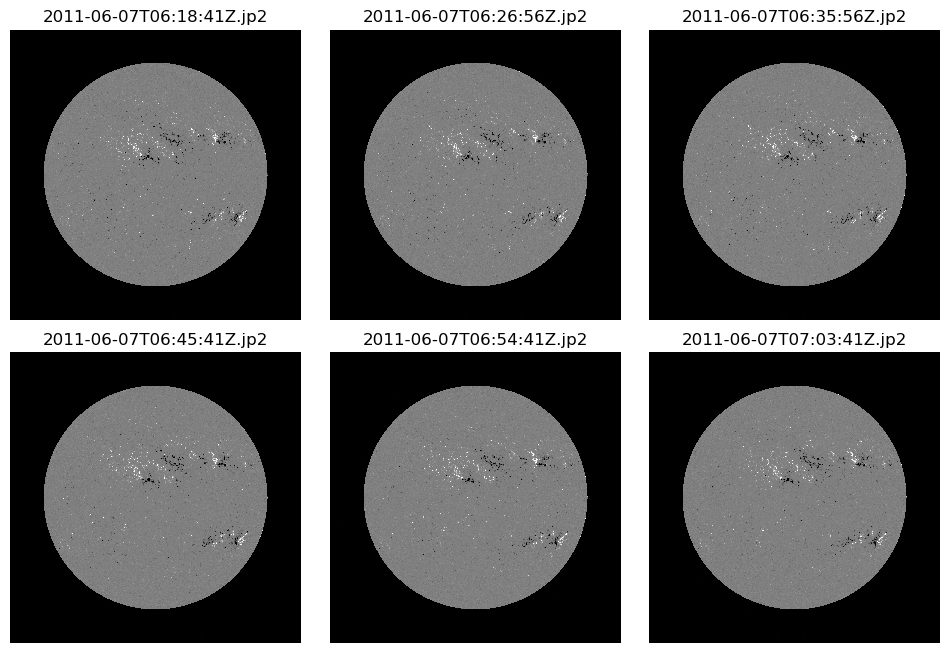

In [21]:
%matplotlib inline

from DONKI.pytorch_dataset import get_flare_array_single_source
import torchvision
import torch


# path = os.path.join(BASE_IMAGE_PATH, "2011-03-07T13:44:00-FLR-001")
path = os.path.join(BASE_IMAGE_PATH, "2011-06-07T06:16:00-FLR-001")
arr, files = get_flare_array_single_source(path, "source_19") # shape (60, 4096, 4096)

import matplotlib.pyplot as plt

num_rows = 2
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

idx = np.linspace(0, 59, num_rows*num_cols, dtype=int)
k = 0
for i in range(num_rows):
    for j in range(num_cols):
        index = idx[k]
        axes[i, j].imshow(arr[index], cmap='gray', interpolation='nearest')
        axes[i, j].axis('off')
        axes[i, j].set_title(files[index])
        k += 1
        
plt.show()